# Introduction
This code is an MCMC fit for sine curves using the emcee package (https://emcee.readthedocs.io/en/stable/). The likelihood function, priors, and random additions are set up for you already. 

### You will be changing:

1.) The initial values of the algorithm - think about how you can find these analytically based on the data that you have

2.) The number of steps the algorithm takes - think about how the number of steps you take affects the quality of your fit

3.) The generated error - think about how error changes how percice your fit can be

### A few thing to note on the items that are being plotted or printed:

1.) Trace: this shows how much your values are moving around during your fit, so how much variation you're getting. The more jagged the plot is, the more variation you get. Note the very jagged part right at the beginning, that's your burn-in. The burn-in is your MCMC figuring out what value it wants to settle on before getting into a holding pattern on that value. It is usually discarded in the next plots.

2.) Corner Plots: these show how constrained the fit is. Good corner plots should look something like this: (https://www.researchgate.net/figure/Corner-plot-resulting-from-our-MCMC-analysis-of-the-TESS-photometry-of-14-Peg-Red_fig1_347534572), where there's a good spread of values that cluster around a central point, which is our correct value. 

3.) The MCMC's Answer: these values are the answers from MCMC with errors. Our errors are calculated by getting the difference between our 50th percentile answer and our 16th percentile answer, and our 84th percentile answer and our 50th percentile answer for our lower error bar and upper error bar, respectively.

4.) Our Final Fitted Plot: note that I declare the model within the plt.plot() call itself. You might want to change this later depending on how you use this algorithm.

### Final Notes:
Values you can and should change are marked with a comment with two exclamation points. Running a 5000 step run takes about three seconds for me, it should take around that amount of time for you. Once you've gotten used to playing around with a generated fit and you've gotten used to sine fitting TOI-4468 without using MCMC, switch over to using the RV data for TOI-4468. It'll provide some interesting challenges, especially given that you will have to phase fold before you input it into the MCMC run.

A few important notes about MCMC. Depending on how your traces look, you might need to throw away more steps in your burn-in. Look for where that the line flattens out, that's how many steps you'll want to throw away. The farther away from the real values your fit is, the larger your burn-in. In MCMC, your fit will be improved the more steps you add, to a point. At a certain point, if you add more steps, you're just wasting time. Since these values have errors on them, we can only be so accurate in our knowledge of the "true value." This is just an approximation, a very good one, but still just an approximation. Keep that in mind before you ask it to run a billion steps. Finally, when you use this code for TOI-4468, I would suggest making a copy of this notebook and editing that so you still have whatever edits you've made here along with the new work you're going to do. I will always have this original copy of the notebook, so if you need it, it's always here.

Hope this is helpful, good luck, and happy fitting!

In [1]:
# Import statements - I use a lot, don't worry about these
import numpy as np

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import emcee

import corner

from IPython.display import display, Math

import matplotlib as mpl
# mpl.rc('font', family='serif', serif='Times New Roman')
# mpl.rcParams['figure.dpi'] = 600
import seaborn as sns
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:96% !important; }</style>"))
%matplotlib inline
import glob 
import pandas as pd
#pd.options.display.max_columns = 100
#pd.options.display.max_rows = 100

# plt.rcParams.update({'figure.figsize': (12,6)})
#from astroquery.simbad import Simbad
#from astroquery.vizier import Vizier
#from astroquery.mast import Observations
#import astropy.units as u

#Keplerspline:
from keplersplinev2 import *
import lightkurve as lk
from astropy.io import fits
import sys

#Batman
import batman

import warnings
warnings.filterwarnings('ignore')

import scipy.stats as stats

from copy import deepcopy
import statistics as st
from astropy.table import Table
import math

In [2]:
# Raw initialization time:

In [3]:
Sector13HLSP = 'S13_Light_Curve.fits'
Sector27HLSP = 'S27_Light_Curve.fits'
Sector67HLSP = 'S67_Light_Curve.fits'



In [4]:
def data_initialization(sector_path):
    clean_flux = []
    clean_time = []
    clean_error = []
    df_name = Table.read(sector_path,  format='fits')
    dataframe = df_name.to_pandas()
    time_name = dataframe.iloc[:,0]
    flux_name = dataframe.iloc[:,7]
    error_name = dataframe.iloc[:,8]
    for i in range(len(flux_name)):
        if not np.isnan(flux_name[i]):
            clean_flux.append(flux_name[i])
            clean_time.append(time_name[i])
            clean_error.append(error_name[i])
    
    clean_flux = np.array(clean_flux)
    clean_time = np.array(clean_time)
    clean_error = np.array(clean_error)
    KS = keplersplinev2(clean_time, clean_flux, bkspace = 0.7)
    #plt.plot(clean_time,clean_flux)
    #plt.plot(clean_time,KS)
    flux_norm = clean_flux/KS
    error_norm = clean_error/KS
    plt.plot(clean_time,flux_norm, '.')
    #error_norm = np.std(flux_norm)
    data = pd.DataFrame(data={'time': clean_time, 'flux': flux_norm, 'error': error_norm})
    
    
    return data

In [5]:
df_name = Table.read(Sector13HLSP,  format='fits')

In [6]:
clean_flux = []
clean_time = []

In [7]:
dataframe = df_name.to_pandas()
time_name = dataframe.iloc[:,0]
flux_name = dataframe.iloc[:,7]


In [8]:
for i in range(len(flux_name)):
        if not np.isnan(flux_name[i]):
            clean_flux.append(flux_name[i])
            clean_time.append(time_name[i])
    
clean_flux = np.array(clean_flux)
clean_time = np.array(clean_time)

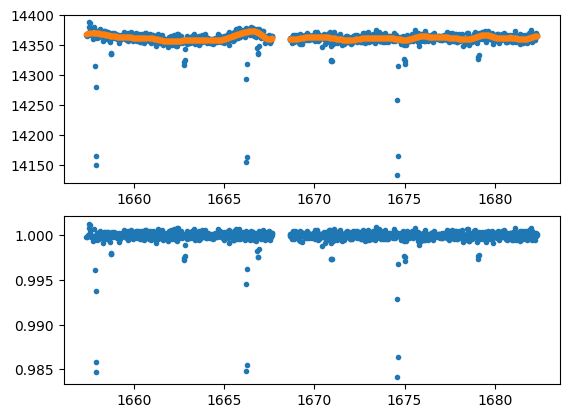

In [9]:
fig, axs = plt.subplots(2)
KS = keplersplinev2(clean_time, clean_flux, bkspace = 0.7)
axs[0].plot(clean_time,clean_flux,'.')
axs[0].plot(clean_time,KS,'.')
flux_norm = clean_flux/KS
error_norm = np.std(flux_norm)

axs[1].plot(clean_time,flux_norm,'.')

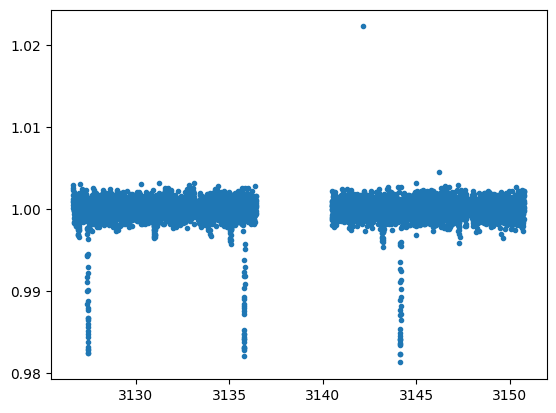

In [10]:
data67HLSP = data_initialization(Sector67HLSP)


             time      flux     error
0     1657.370409  0.999837  0.000293
1     1657.391243  0.999781  0.000292
2     1657.474577  1.000046  0.000292
3     1657.516245  1.001275  0.000293
4     1657.537078  1.000778  0.000293
...           ...       ...       ...
8284  3150.742288  0.999846  0.000947
8285  3150.744602  1.002207  0.000949
8286  3150.746917  1.000732  0.000948
8287  3150.749232  1.000260  0.000949
8288  3150.751547  1.001517  0.000949

[12066 rows x 3 columns]


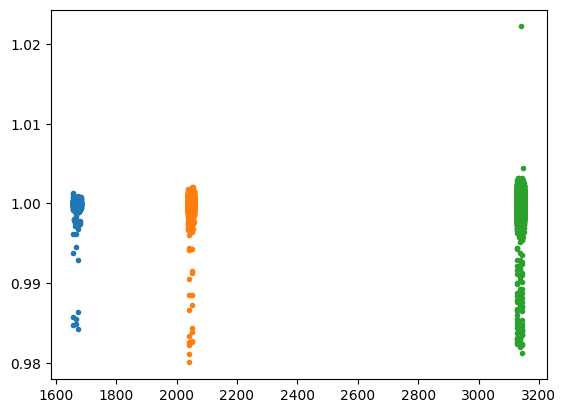

In [11]:
TTVdataframe = []
data13HLSP = data_initialization(Sector13HLSP)
data27HLSP = data_initialization(Sector27HLSP)
data67HLSP = data_initialization(Sector67HLSP)


concat_targets = [data13HLSP, data27HLSP, data67HLSP]
TTVdataframe = pd.concat(concat_targets)
print((TTVdataframe))
time = TTVdataframe.iloc[:,0]
flux = TTVdataframe.iloc[:,1]
error = TTVdataframe.iloc[:,2]

In [12]:
#Creation of original values
period = 8.3501898
best_t0 =  3127.4353041#2050.3458827

In [13]:
epoch = np.arange(min(TTVdataframe.iloc[:,0]) + ((best_t0-min(TTVdataframe.iloc[:,0]))%period), max(TTVdataframe.iloc[:,0]), period)
#(t0-min(t))%p_orb)), max(t), p_orb)
print(epoch)

[1657.8018993 1666.1520891 1674.5022789 1682.8524687 1691.2026585
 1699.5528483 1707.9030381 1716.2532279 1724.6034177 1732.9536075
 1741.3037973 1749.6539871 1758.0041769 1766.3543667 1774.7045565
 1783.0547463 1791.4049361 1799.7551259 1808.1053157 1816.4555055
 1824.8056953 1833.1558851 1841.5060749 1849.8562647 1858.2064545
 1866.5566443 1874.9068341 1883.2570239 1891.6072137 1899.9574035
 1908.3075933 1916.6577831 1925.0079729 1933.3581627 1941.7083525
 1950.0585423 1958.4087321 1966.7589219 1975.1091117 1983.4593015
 1991.8094913 2000.1596811 2008.5098709 2016.8600607 2025.2102505
 2033.5604403 2041.9106301 2050.2608199 2058.6110097 2066.9611995
 2075.3113893 2083.6615791 2092.0117689 2100.3619587 2108.7121485
 2117.0623383 2125.4125281 2133.7627179 2142.1129077 2150.4630975
 2158.8132873 2167.1634771 2175.5136669 2183.8638567 2192.2140465
 2200.5642363 2208.9144261 2217.2646159 2225.6148057 2233.9649955
 2242.3151853 2250.6653751 2259.0155649 2267.3657547 2275.7159445
 2284.0661

<ErrorbarContainer object of 3 artists>

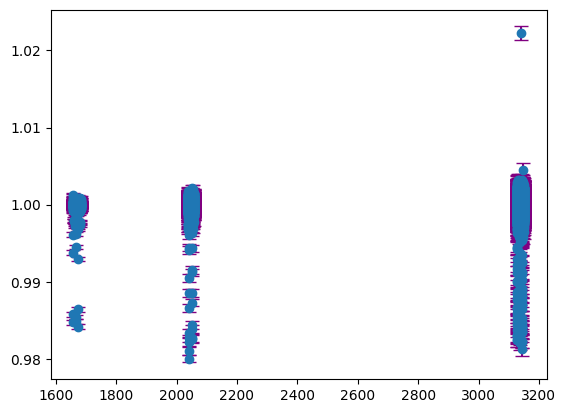

In [14]:
plt.errorbar(TTVdataframe.iloc[:,0], TTVdataframe.iloc[:,1], yerr=TTVdataframe.iloc[:,2], ecolor='purple', fmt='o', capsize=5, label="Data with asymmetric errors")

In [15]:
params = batman.TransitParams()       #object to store transit parameters
params.per = 8.3501898                 #orbital period(days) TRY TO VARY
params.rp = (1.16*0.100493)/0.687          #planet radius (in units of stellar radii)
params.a = 0.0731*215.032/0.687                 #semi-major axis (in units of stellar radii) TRY TO VARY
params.inc = 87.61                      #orbital inclination (in degrees)
params.ecc = 0.0398                      #eccentricity
params.w = 182.5                         #longitude of periastron (in degrees)
params.limb_dark = "quadratic"        #limb darkening model
params.u = [0.1,0.3]      #limb darkening coefficients [u1, u2, u3, u4]

In [16]:
#NOTE: ratio of planet radius to stellar radius
#Defining the Transit Model:
params.t0 = 3135.7867100#epochs[0]                       #time of inferior conjunction
time_example = TTVdataframe.loc[(TTVdataframe['time'] > 3135.7867100 - 0.4) & (TTVdataframe['time'] < 3135.7867100 + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['time']]
flux_example = TTVdataframe.loc[(TTVdataframe['time'] > 3135.7867100 - 0.4) & (TTVdataframe['time'] < 3135.7867100 + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['flux']]
error_example = TTVdataframe.loc[(TTVdataframe['time'] > 3135.7867100 - 0.4) & (TTVdataframe['time'] < 3135.7867100 + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['error']]
m = batman.TransitModel(params, np.asarray(time_example.values.flatten()))    #initializes model

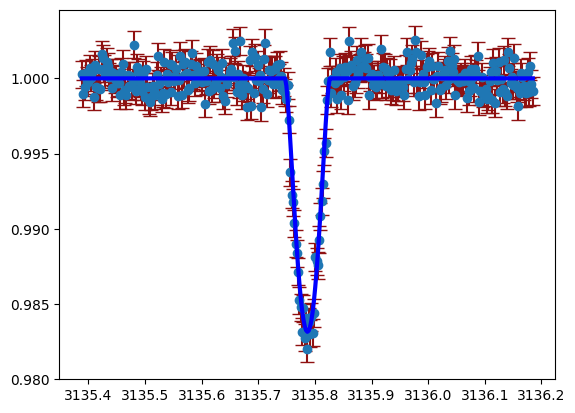

In [17]:
#params.inc = i                           #updates planet radius
new_flux = m.light_curve(params)        #recalculates light curve
plt.plot(time_example.values.flatten(), flux_example.values.flatten(), '.', color = 'black')
plt.errorbar(time_example.values.flatten(), flux_example.values.flatten(), yerr=error_example.values.flatten(), ecolor='#8f1111', fmt='o', capsize=5, label="Data with asymmetric errors")
plt.plot(time_example.values.flatten(), new_flux,'blue',linewidth=3, zorder=10)

In [18]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    t0, rp = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if e+0.4>t0>e-0.4 and 0.25>rp>0.1: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

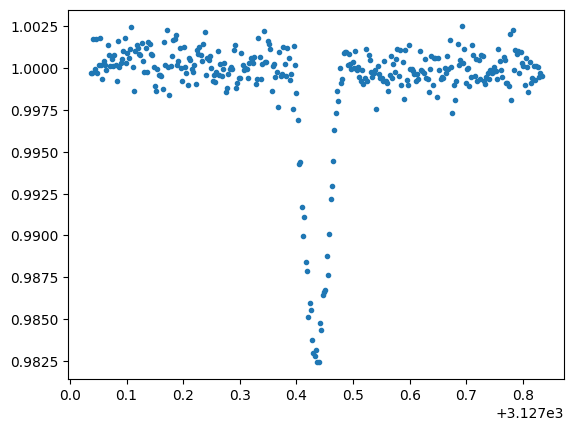

In [19]:
epochs_sim = 3127.435
time_temp = time[(time > epochs_sim - 0.4) & (time < epochs_sim + 0.4)]
flux_temp = flux[(time > epochs_sim - 0.4) & (time < epochs_sim + 0.4)]
plt.plot(time_temp,flux_temp,'.')

In [20]:
# Define Likelihood Function
def log_likelihood_TTV(params, time, flux, flux_err):
    ## Get our parameters for the model
    t0, rp= params
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely

    lp = log_prior((t0, rp))
    if not np.isfinite(lp):
        return -np.inf
    params = batman.TransitParams()
    params.per = 8.3501898                 #orbital period(days) TRY TO VARY
    #params.rp = (1.16*0.100493)/0.687          #planet radius (in units of stellar radii)
    params.a = 0.0731*215.032/0.687                 #semi-major axis (in units of stellar radii) TRY TO VARY
    params.inc = 87.61                      #orbital inclination (in degrees)
    params.ecc = 0.0398                      #eccentricity
    params.w = 182.5                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.1,0.3]      #limb darkening coefficients [u1, u2, u3, u4]
    params.t0 = t0
    params.rp = rp
    
    ## Generate a new version of our model using our current x values
    model = batman.TransitModel(params, time)
    model_flux = model.light_curve(params)
    
    
    ## Compare using chi squared
    residuals = flux - model_flux
    ## Return our chi squared value for later evaluation done by emcee
    return -0.5 * np.sum((residuals**2) / (flux_err**2))

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 239.09it/s]


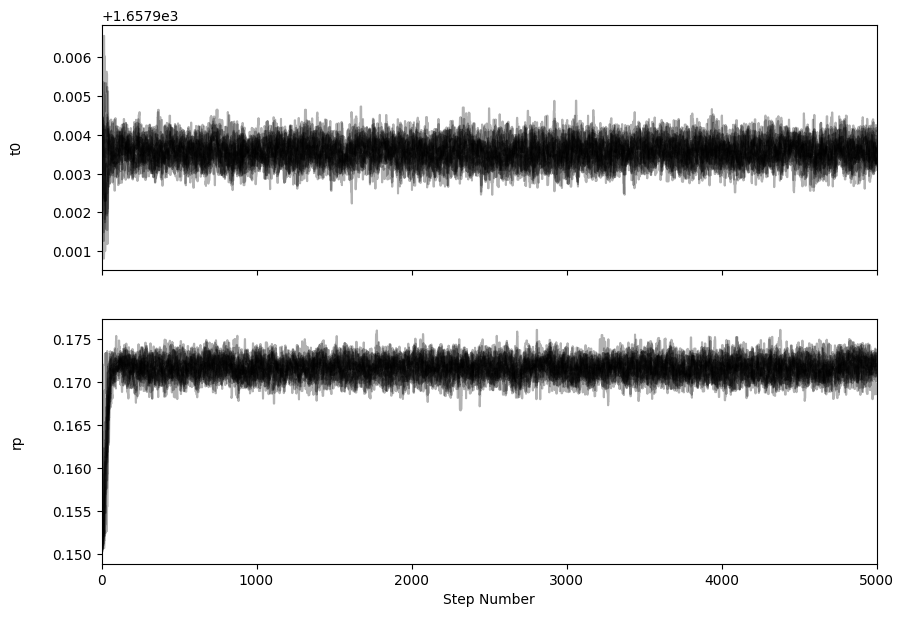

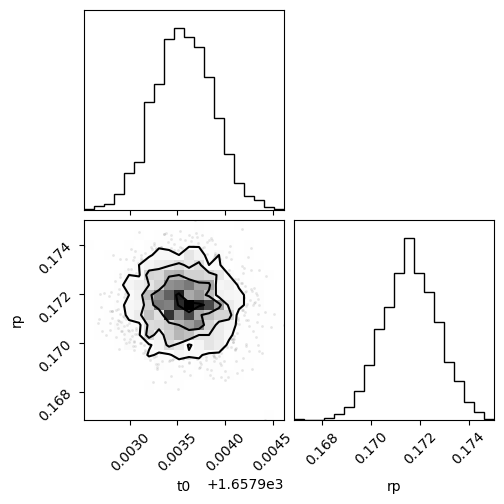

<IPython.core.display.Math object>

<IPython.core.display.Math object>

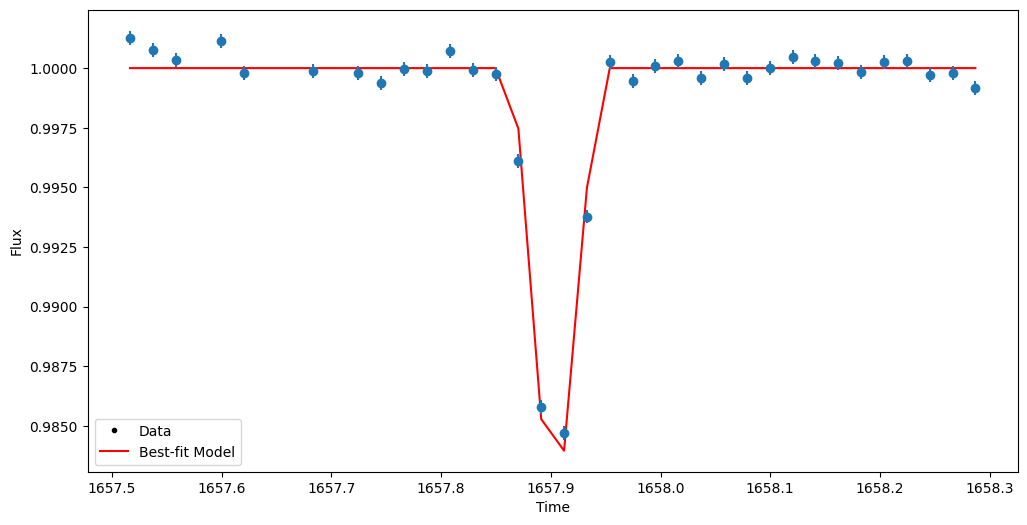

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 233.46it/s]


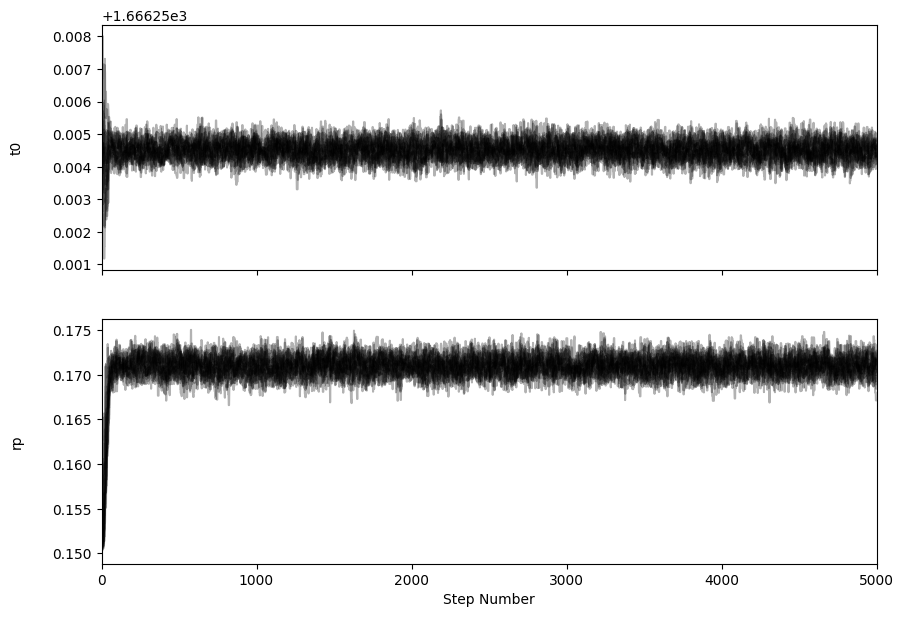

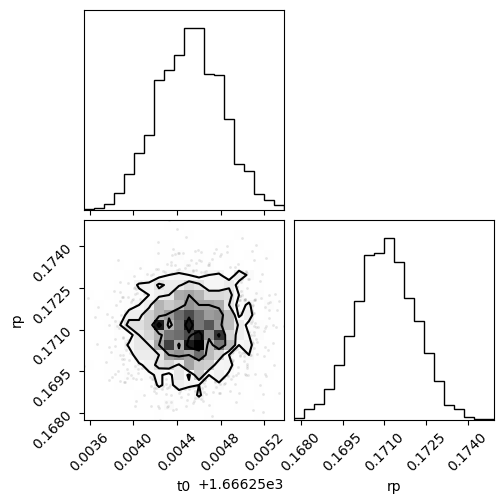

<IPython.core.display.Math object>

<IPython.core.display.Math object>

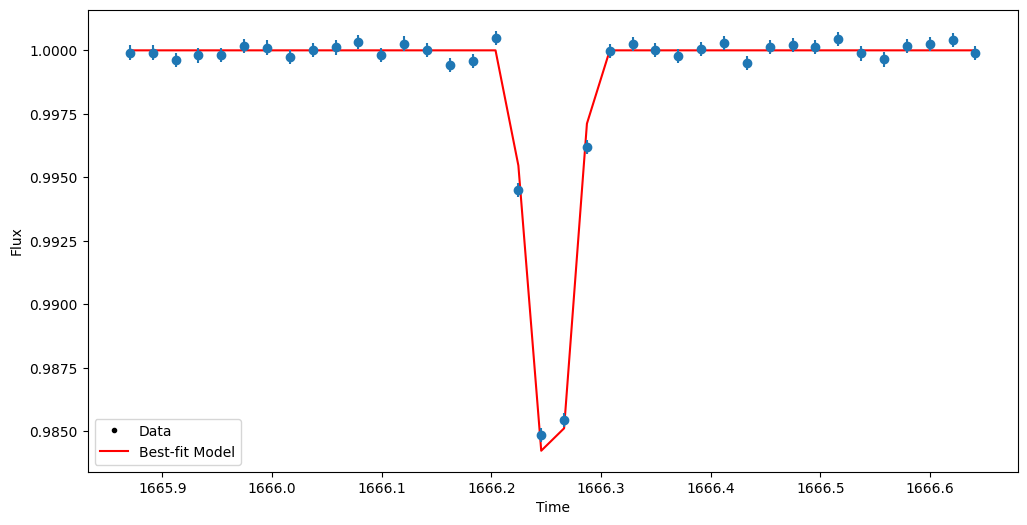

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 245.80it/s]


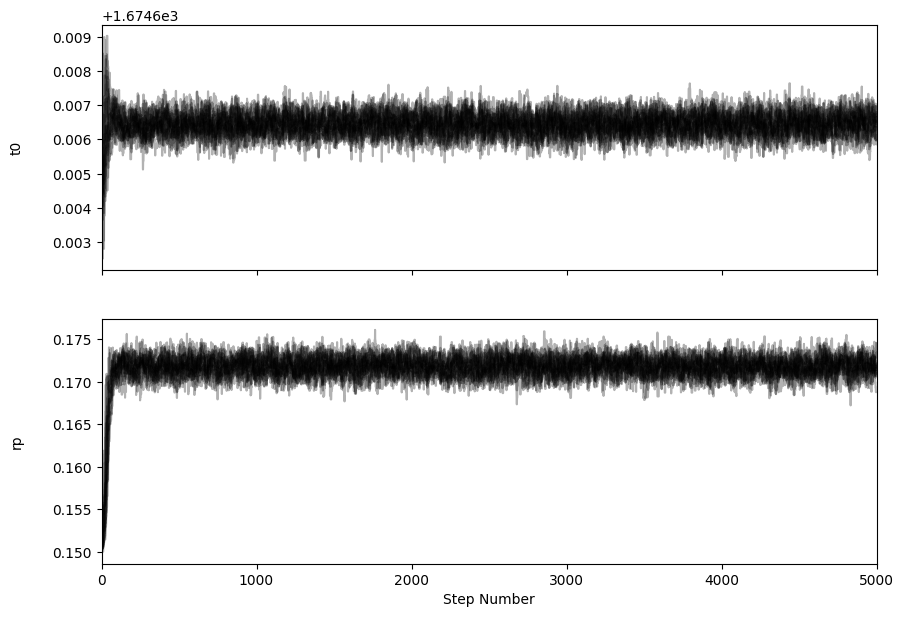

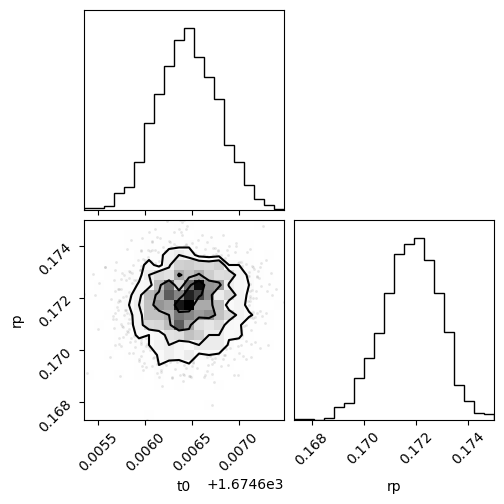

<IPython.core.display.Math object>

<IPython.core.display.Math object>

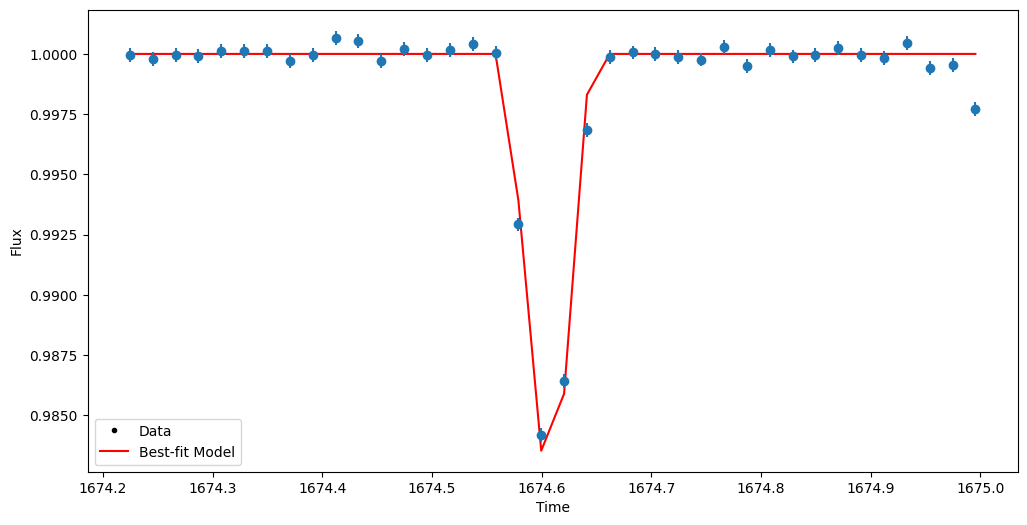

In [22]:
ndim = 2
nwalkers = 16
# Store t0 values for each epoch fit
t0values = []
t0values_upper = []
t0values_lower = []
rpvalues = []
rpvalues_upper = []
rpvalues_lower = []
best_t0 = 1657.9035509
epochs = np.arange(min(data13HLSP.iloc[:,0]) + ((best_t0-min(data13HLSP.iloc[:,0]))%period), max(data13HLSP.iloc[:,0]), period)
for e in epochs:  # Adjust range based on the number of epochs
        # Initialize walkers around the current epoch's t0 value
        time_temp = []
        flux_temp = []
        error_temp = []
            
        time_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['time']]
        flux_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['flux']]
        error_temp = TTVdataframe.loc[(TTVdataframe['time'] > e  - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['error']]
    
        if np.isscalar(time_temp) == True:
            t0values.append(np.nan)
            t0values_upper.append(np.nan)
            t0values_lower.append(np.nan)
            rpvalues.append(np.nan)
            rpvalues_upper.append(np.nan)
            rpvalues_lower.append(np.nan)
            continue
        elif len(time_temp) < 30:
            t0values.append(np.nan)
            t0values_upper.append(np.nan)
            t0values_lower.append(np.nan)
            rpvalues.append(np.nan)
            rpvalues_upper.append(np.nan)
            rpvalues_lower.append(np.nan)
            continue
        else:
            t0_guess = e 
            rp_guess = 0.15
            random_additions = np.random.rand(nwalkers, ndim) * 0.001
            p0 = np.add([t0_guess, rp_guess], random_additions)
        
            # Declare the sampler for the current epoch
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_likelihood_TTV,
                args=(np.asarray(time_temp.values.flatten()), np.asarray(flux_temp.values.flatten()), np.asarray(error_temp.values.flatten()))
            )
            sampler.run_mcmc(p0, 5000, progress=True)
    
            # Retrieve samples and plot the trace for current epoch
            samples = sampler.get_chain()
            fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
            labels = ['t0','rp']
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("Step Number")
            plt.show()
    
            # Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
            flat_samples = sampler.get_chain(discard=1000, thin=30, flat=True)
            fig = corner.corner(flat_samples, labels=labels)
            plt.show()
    
                # Calculate and display median and uncertainties for t0
            mcmc_t0 = np.percentile(flat_samples[:, 0], [16, 50, 84])
            q_t0 = np.diff(mcmc_t0)
            mcmc_rp = np.percentile(flat_samples[:, 1], [16, 50, 84])
            q_rp = np.diff(mcmc_rp)
            txt_t0 = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
            txt_t0 = txt_t0.format(mcmc_t0[1], q_t0[0], q_t0[1], labels[0])
            display(Math(txt_t0))
            txt_rp = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
            txt_rp = txt_rp.format(mcmc_rp[1], q_rp[0], q_rp[1], labels[1])
            display(Math(txt_rp))
        
            # Save the best-fit t0 value for this epoch
            t0values.append(mcmc_t0[1])
            t0values_upper.append(q_t0[1])
            t0values_lower.append(q_t0[0])
            rpvalues.append(mcmc_rp[1])
            rpvalues_upper.append(q_rp[1])
            rpvalues_lower.append(q_rp[0])
            # Update model with best-fit t0 to plot the fitted light curve
            params.t0 = mcmc_t0[1]
            params.rp = mcmc_rp[1]
            best_fit = batman.TransitModel(params, time_temp.values.flatten())  # Use BATMAN with current t0
            best_flux = best_fit.light_curve(params)
    
            # Plot data and best-fit model for the current epoch
            plt.figure(figsize=(12, 6))
            plt.plot(time_temp.values.flatten(), flux_temp.values.flatten(), "k.", label="Data")
            plt.plot(time_temp.values.flatten(), best_flux, "r-", label="Best-fit Model")
            plt.errorbar(time_temp.values.flatten(), flux_temp.values.flatten(), yerr = error_temp.values.flatten(), fmt='o')
            plt.xlabel("Time")
            plt.ylabel("Flux")
            plt.legend()
            plt.show() 

In [23]:
print((t0values))

[np.float64(1657.9035619429044), np.float64(1666.2545229010602), np.float64(1674.606447369597)]


Processing Dataset              time      flux     error
0     1657.370409  0.999837  0.000293
1     1657.391243  0.999781  0.000292
2     1657.474577  1.000046  0.000292
3     1657.516245  1.001275  0.000293
4     1657.537078  1.000778  0.000293
...           ...       ...       ...
1116  1682.266249  0.999906  0.000282
1117  1682.287082  0.999937  0.000282
1118  1682.307915  1.000310  0.000282
1119  1682.328748  0.999987  0.000282
1120  1682.349581  1.000120  0.000282

[1121 rows x 3 columns]


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:20<00:00, 246.53it/s]


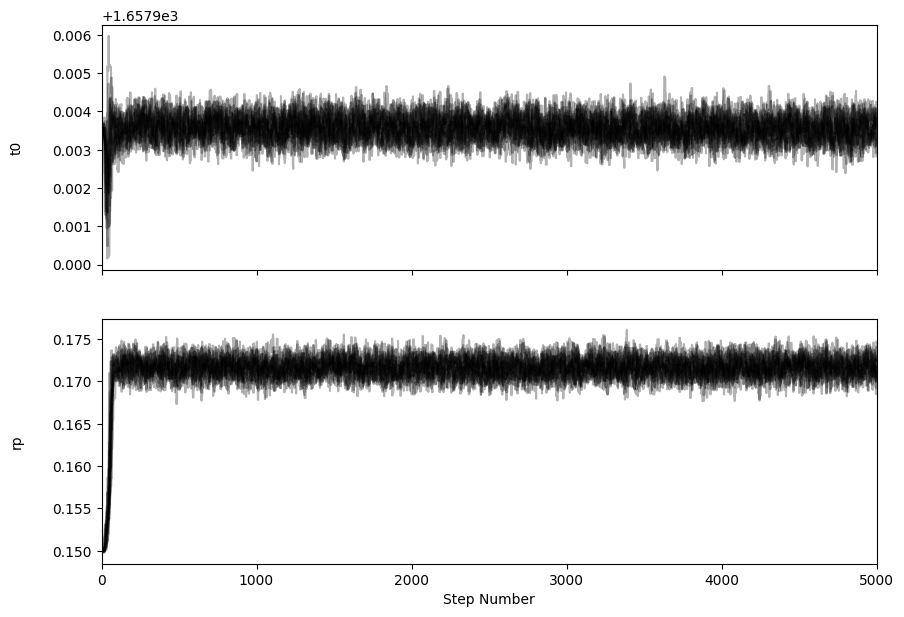

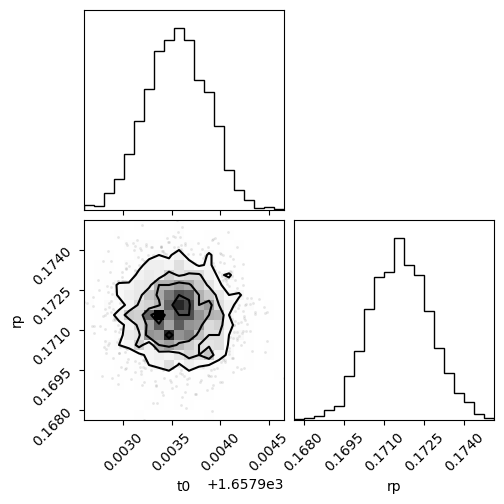

<IPython.core.display.Math object>

<IPython.core.display.Math object>

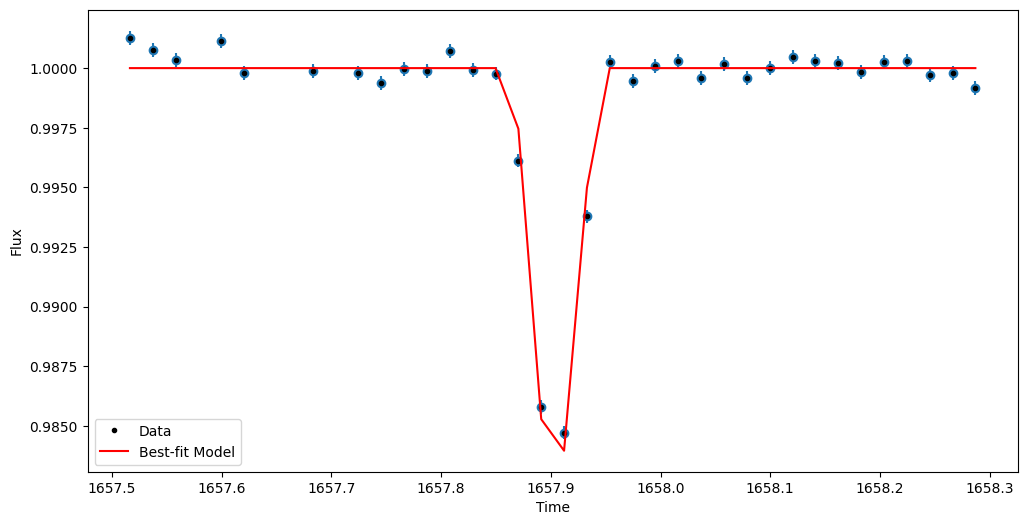

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:21<00:00, 228.46it/s]


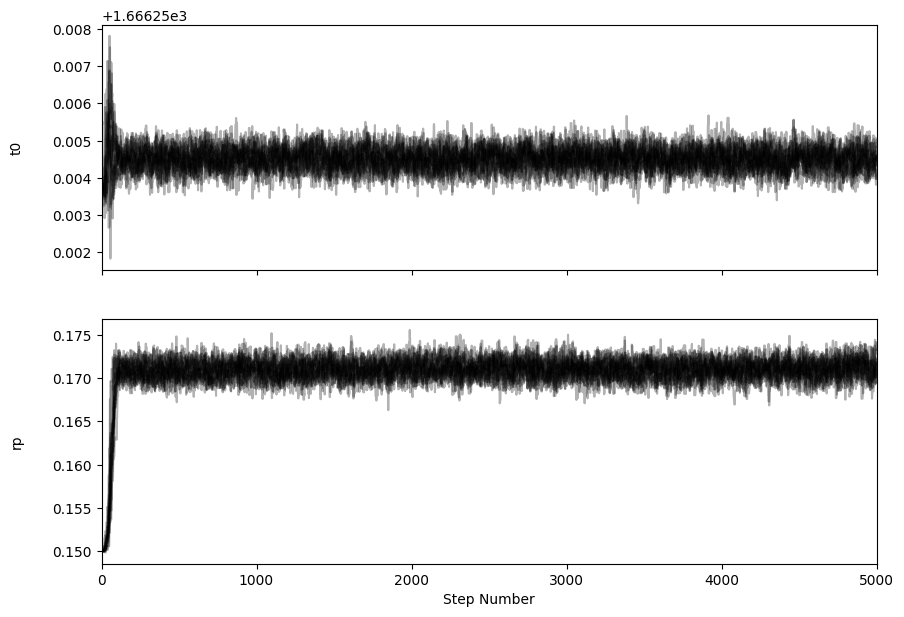

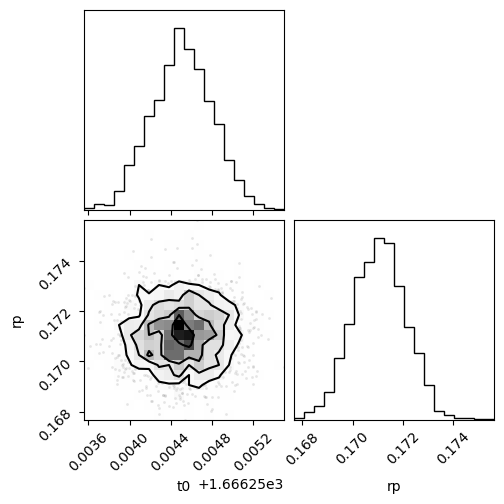

<IPython.core.display.Math object>

<IPython.core.display.Math object>

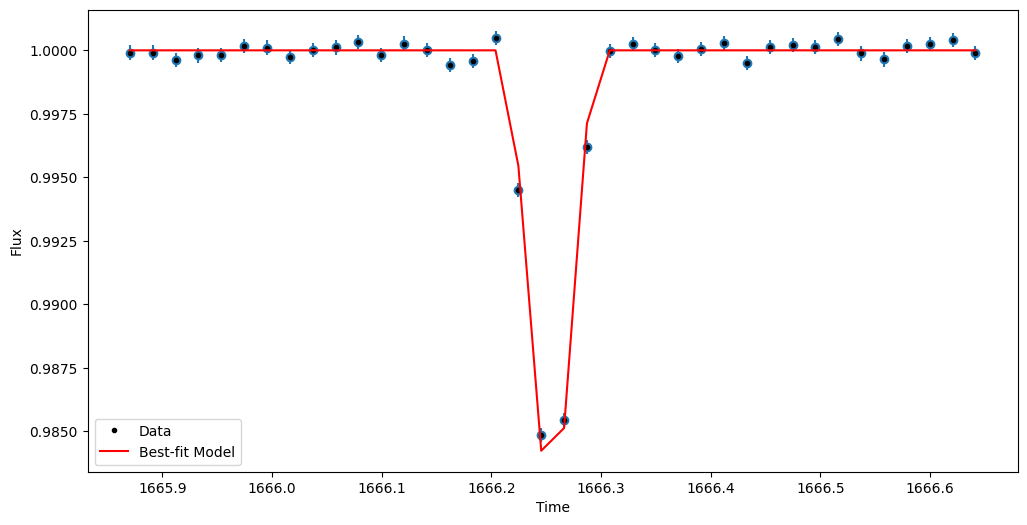

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 251.19it/s]


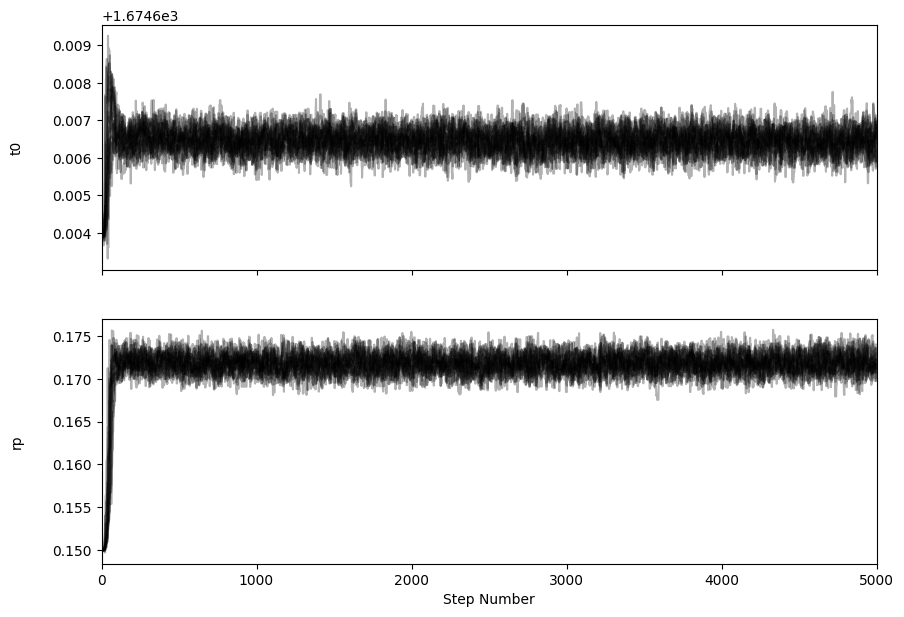

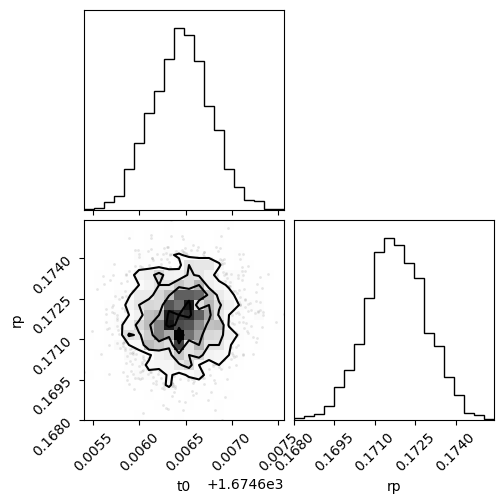

<IPython.core.display.Math object>

<IPython.core.display.Math object>

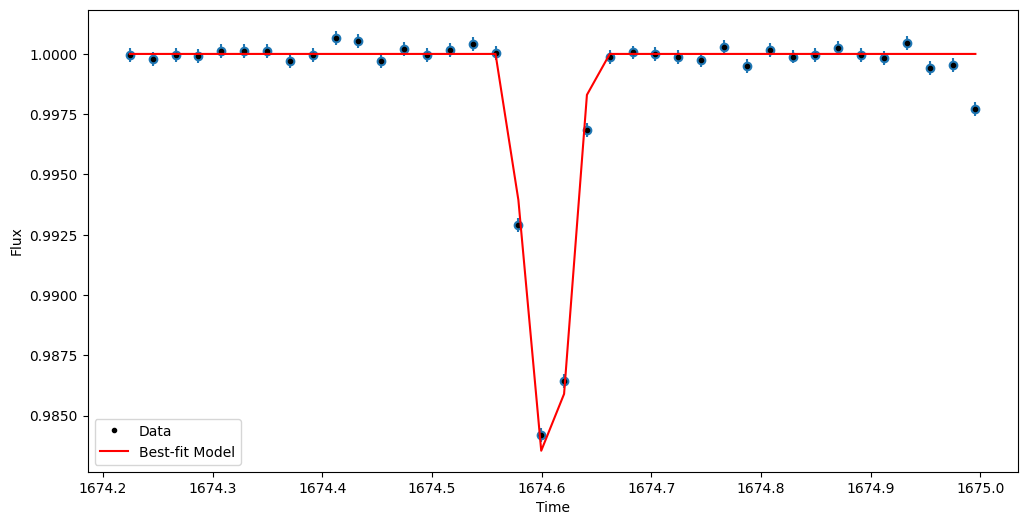

Processing Dataset              time      flux     error
0     2036.293986  0.999635  0.000499
1     2036.300930  0.999410  0.000499
2     2036.307875  1.000490  0.000500
3     2036.314819  1.000062  0.000499
4     2036.321763  0.999258  0.000499
...           ...       ...       ...
2651  2058.453274  1.000264  0.000526
2652  2058.460218  1.000089  0.000526
2653  2058.467163  1.000107  0.000526
2654  2058.474107  0.999444  0.000526
2655  2058.481051  0.999967  0.000527

[2656 rows x 3 columns]


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 169.70it/s]


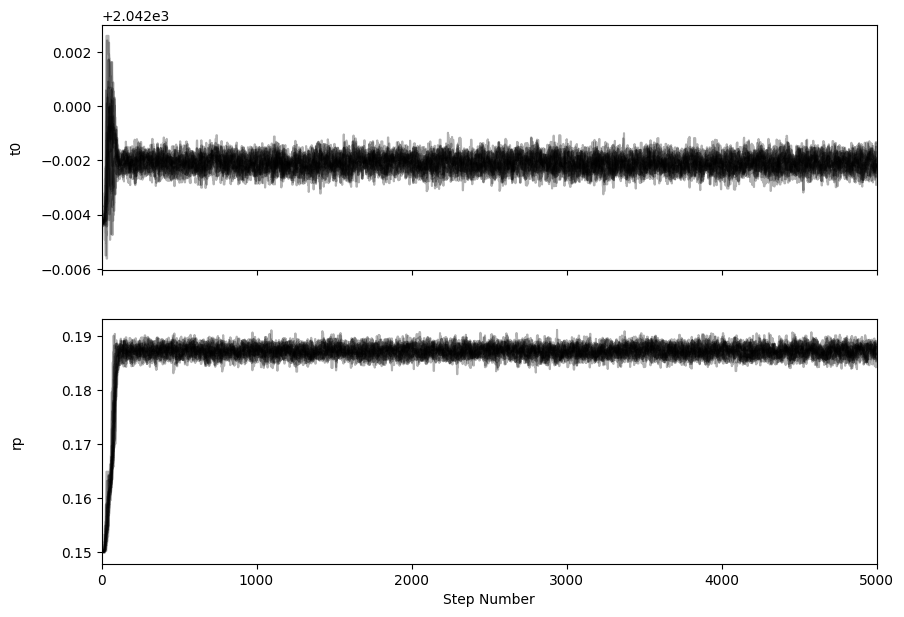

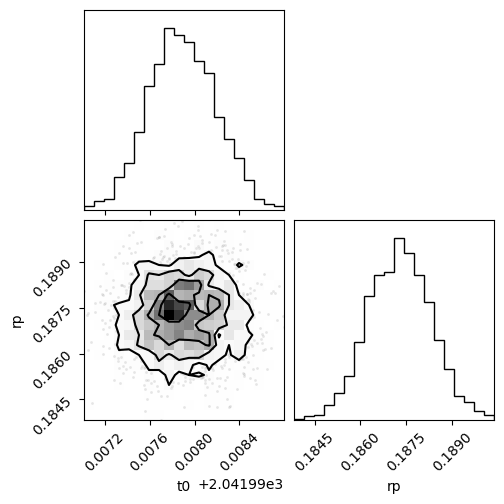

<IPython.core.display.Math object>

<IPython.core.display.Math object>

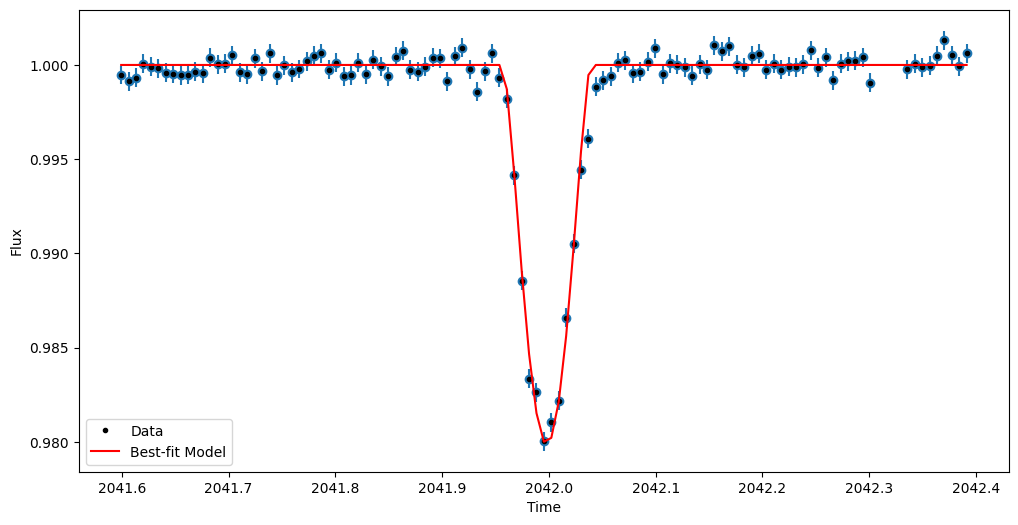

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:31<00:00, 159.07it/s]


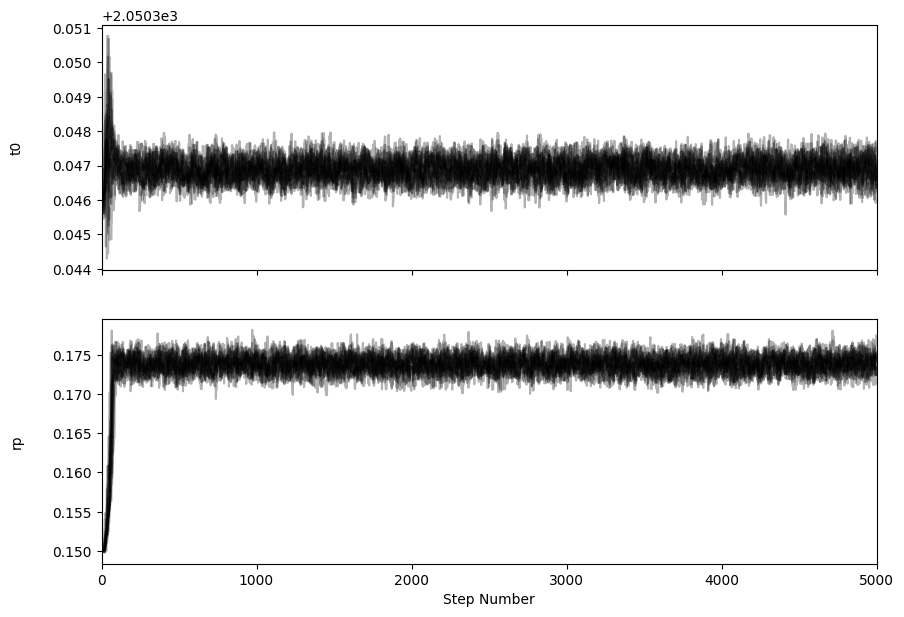

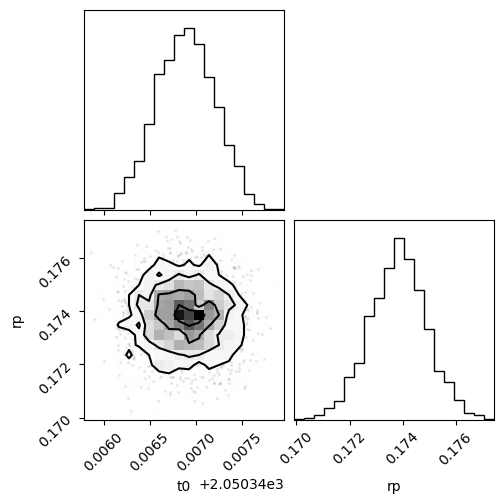

<IPython.core.display.Math object>

<IPython.core.display.Math object>

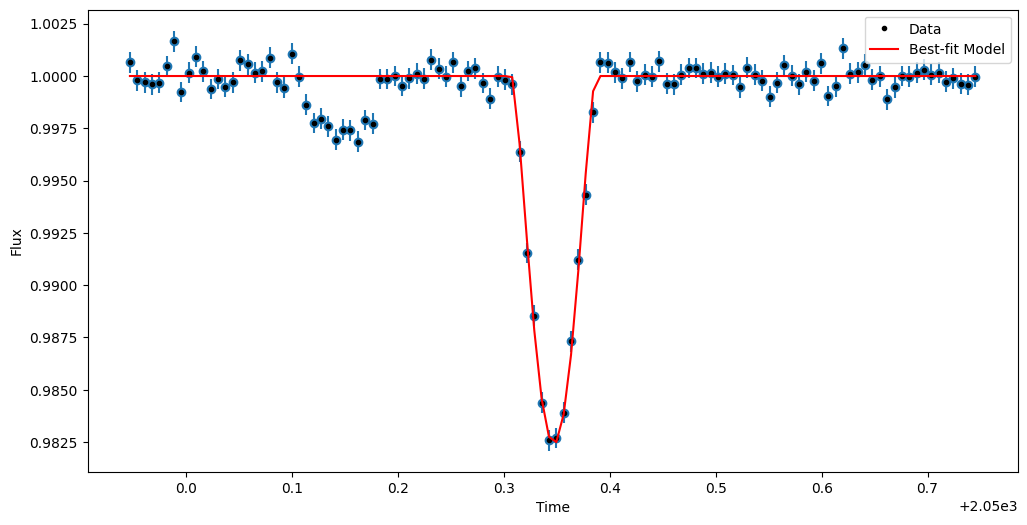

Processing Dataset              time      flux     error
0     3126.650006  1.000424  0.000879
1     3126.652321  1.002504  0.000879
2     3126.654636  1.000814  0.000879
3     3126.656951  1.001667  0.000879
4     3126.659266  1.000112  0.000879
...           ...       ...       ...
8284  3150.742288  0.999846  0.000947
8285  3150.744602  1.002207  0.000949
8286  3150.746917  1.000732  0.000948
8287  3150.749232  1.000260  0.000949
8288  3150.751547  1.001517  0.000949

[8289 rows x 3 columns]


100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 126.58it/s]


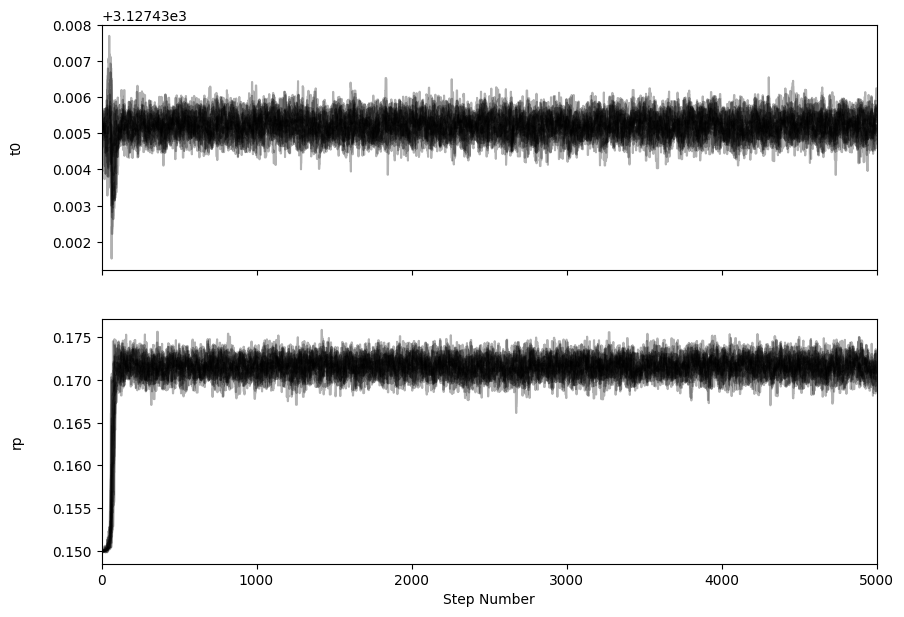

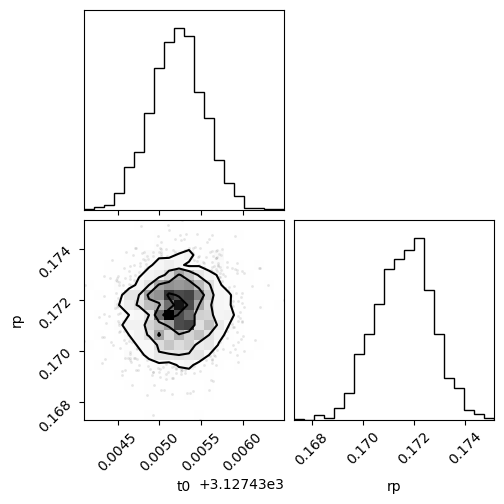

<IPython.core.display.Math object>

<IPython.core.display.Math object>

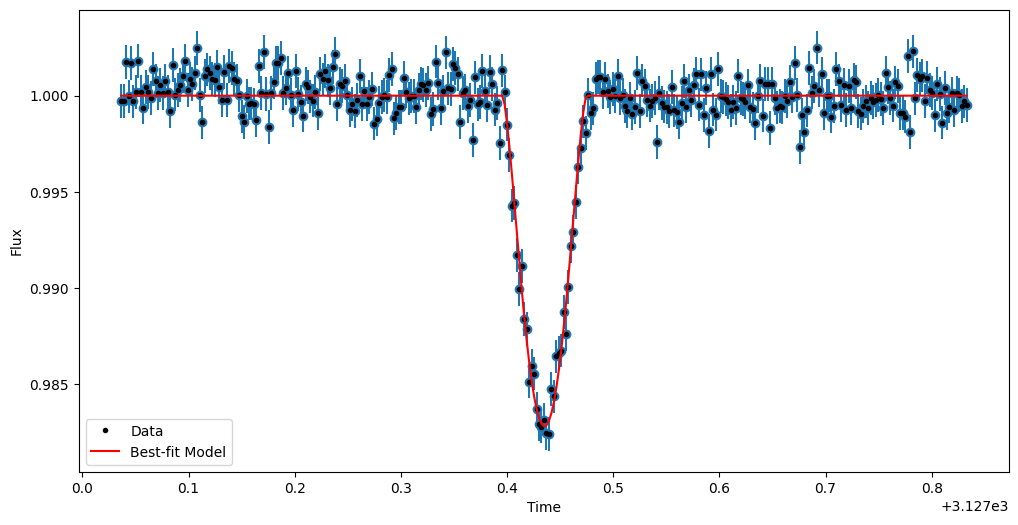

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:30<00:00, 166.07it/s]


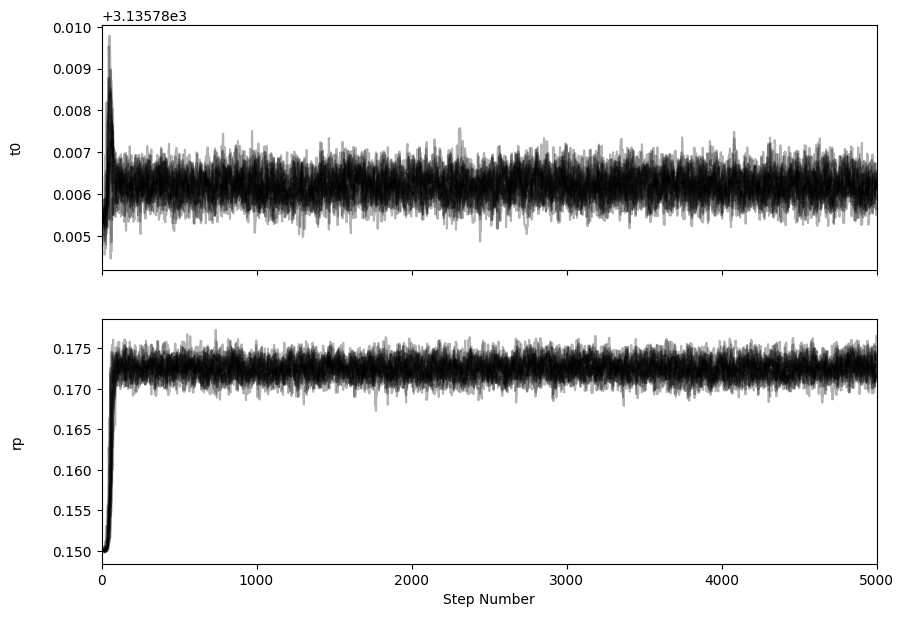

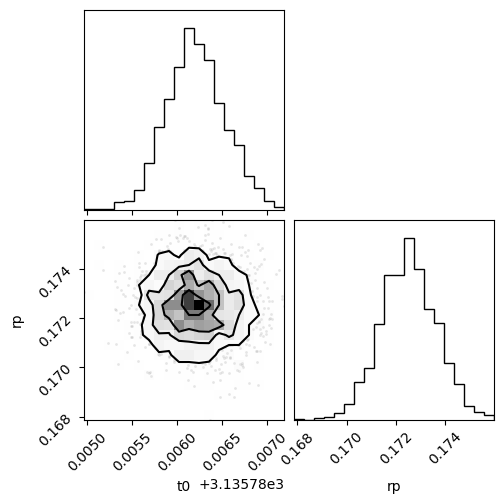

<IPython.core.display.Math object>

<IPython.core.display.Math object>

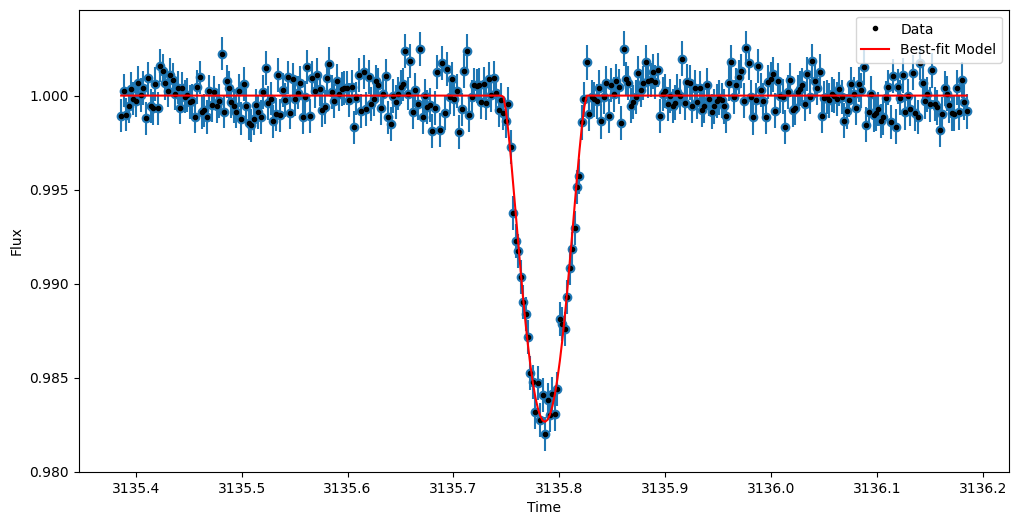

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:50<00:00, 98.20it/s]


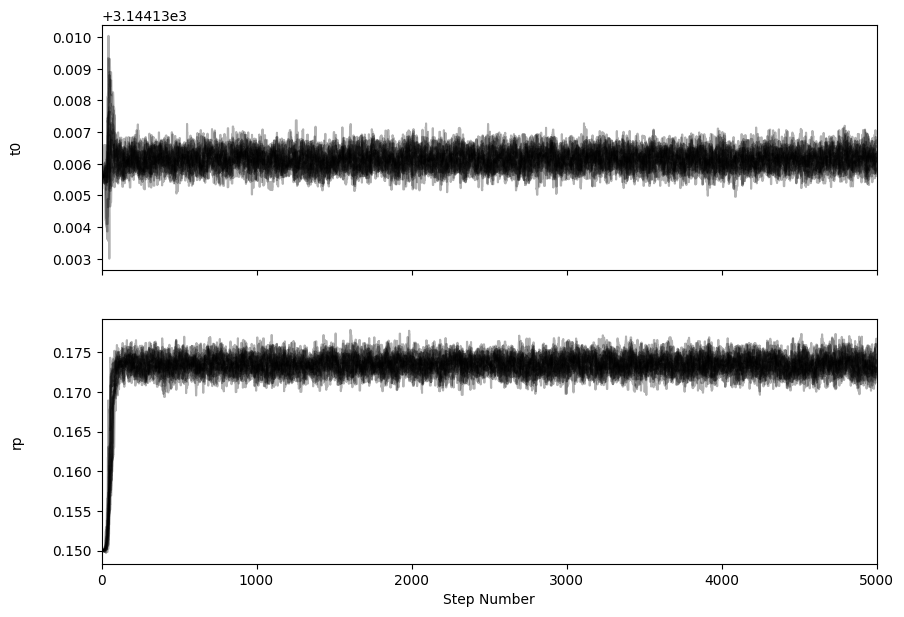

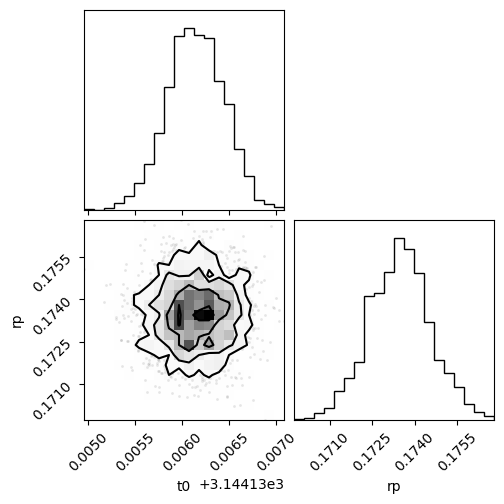

<IPython.core.display.Math object>

<IPython.core.display.Math object>

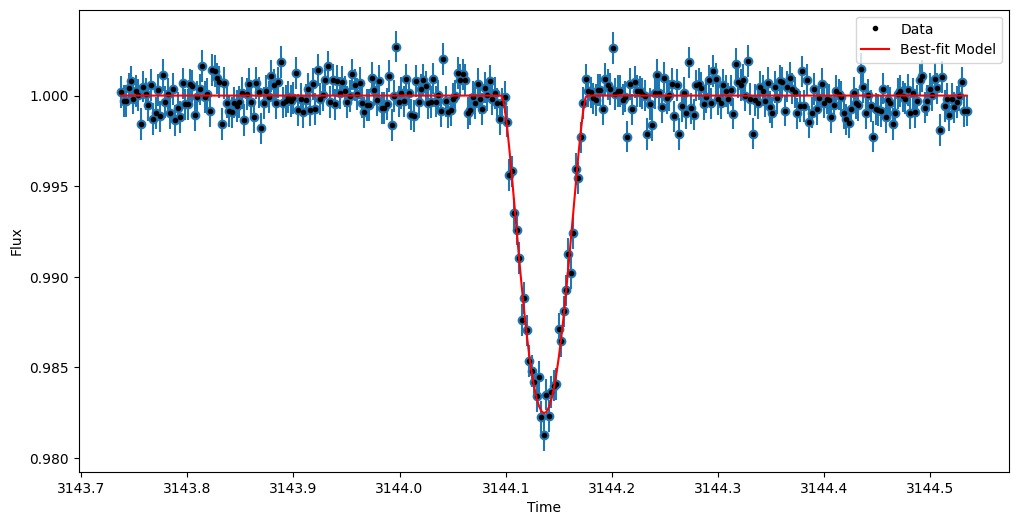

In [24]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 2
nwalkers = 16
 
# Store t0 values for each epoch fit
t0values = []
t0values_upper = []
t0values_lower = []
rpvalues = []
rpvalues_upper = []
rpvalues_lower = []
dataset = concat_targets
for i in dataset:
    if i is data13HLSP:
        best_t0 = 1657.9035509
        best_t0_next = 2041.9978801
    if i is data27HLSP:
        best_t0 = 2050.3458827
        best_t0_next = 3127.4351963
    if i is data67HLSP:
        best_t0 = 3127.4351963
        best_t0_next = 3127.4351963
    
    print(f"Processing Dataset", i)
    epochs = np.arange(min(i.iloc[:,0]) + ((best_t0-min(i.iloc[:,0]))%period), max(i.iloc[:,0]), period)
    
    for e in epochs:  # Adjust range based on the number of epochs
        # Initialize walkers around the current epoch's t0 value
        time_temp = []
        flux_temp = []
        error_temp = []
            
        time_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['time']]
        flux_temp = TTVdataframe.loc[(TTVdataframe['time'] > e - 0.4) & (TTVdataframe['time'] < e  + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['flux']]
        error_temp = TTVdataframe.loc[(TTVdataframe['time'] > e  - 0.4) & (TTVdataframe['time'] < e + 0.4) & (pd.notnull(TTVdataframe['flux'])), ['error']]
    
        if np.isscalar(time_temp) == True:
            t0values.append(np.nan)
            t0values_upper.append(np.nan)
            t0values_lower.append(np.nan)
            rpvalues.append(np.nan)
            rpvalues_upper.append(np.nan)
            rpvalues_lower.append(np.nan)
            continue
        elif len(time_temp) < 30:
            t0values.append(np.nan)
            t0values_upper.append(np.nan)
            t0values_lower.append(np.nan)
            rpvalues.append(np.nan)
            rpvalues_upper.append(np.nan)
            rpvalues_lower.append(np.nan)
            continue
        else:
            t0_guess = e 
            rp_guess = 0.15
            random_additions = np.random.rand(nwalkers, ndim) * 0.00001
            p0 = np.add([t0_guess, rp_guess], random_additions)
        
            # Declare the sampler for the current epoch
            sampler = emcee.EnsembleSampler(
                nwalkers, ndim, log_likelihood_TTV,
                args=(np.asarray(time_temp.values.flatten()), np.asarray(flux_temp.values.flatten()), np.asarray(error_temp.values.flatten()))
            )
            sampler.run_mcmc(p0, 5000, progress=True)
    
            # Retrieve samples and plot the trace for current epoch
            samples = sampler.get_chain()
            fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
            labels = ['t0','rp']
            for i in range(ndim):
                ax = axes[i]
                ax.plot(samples[:, :, i], "k", alpha=0.3)
                ax.set_xlim(0, len(samples))
                ax.set_ylabel(labels[i])
                ax.yaxis.set_label_coords(-0.1, 0.5)
                axes[-1].set_xlabel("Step Number")
            plt.show()
    
            # Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
            flat_samples = sampler.get_chain(discard=1000, thin=30, flat=True)
            fig = corner.corner(flat_samples, labels=labels)
            plt.show()
    
            # Calculate and display median and uncertainties for t0
            mcmc_t0 = np.percentile(flat_samples[:, 0], [0.3, 50, 99.7])
            q_t0 = np.diff(mcmc_t0)
            mcmc_rp = np.percentile(flat_samples[:, 1], [0.3, 50, 99.7])
            q_rp = np.diff(mcmc_rp)
            txt_t0 = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
            txt_t0 = txt_t0.format(mcmc_t0[1], q_t0[0], q_t0[1], labels[0])
            display(Math(txt_t0))
            txt_rp = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
            txt_rp = txt_rp.format(mcmc_rp[1], q_rp[0], q_rp[1], labels[1])
            display(Math(txt_rp))
        
            # Save the best-fit t0 value for this epoch
            t0values.append(mcmc_t0[1])
            t0values_upper.append(q_t0[1])
            t0values_lower.append(q_t0[0])
            rpvalues.append(mcmc_rp[1])
            rpvalues_upper.append(q_rp[1])
            rpvalues_lower.append(q_rp[0])
            # Update model with best-fit t0 to plot the fitted light curve
            params.t0 = mcmc_t0[1]
            params.rp = mcmc_rp[1]
            best_fit = batman.TransitModel(params, time_temp.values.flatten())  # Use BATMAN with current t0
            best_flux = best_fit.light_curve(params)
    
            # Plot data and best-fit model for the current epoch
            plt.figure(figsize=(12, 6))
            plt.errorbar(time_temp.values.flatten(), flux_temp.values.flatten(), yerr = error_temp.values.flatten(), fmt='o',zorder = 0)
            plt.plot(time_temp.values.flatten(), flux_temp.values.flatten(), "k.", label="Data",zorder = 1)
            plt.plot(time_temp.values.flatten(), best_flux, "r-", label="Best-fit Model", zorder = 2)
            plt.xlabel("Time")
            plt.ylabel("Flux")
            plt.legend()
            plt.show()
            
    for i in range(math.trunc((best_t0_next-epochs[len(epochs)-1])/period)):
        t0values.append(np.nan)
        t0values_upper.append(np.nan)
        t0values_lower.append(np.nan)
        rpvalues.append(np.nan)
        rpvalues_upper.append(np.nan)
        rpvalues_lower.append(np.nan)    
    
    # At the end, `t0values` contains the best-fit t0 for each epoch.


In [25]:
print((t0values))

[np.float64(1657.90355818509), np.float64(1666.2545069017785), np.float64(1674.606459126036), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, np.float64(2041.997884260778), np.float64(2050.3468892857836), nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan

In [26]:
print(len(t0values))

179


In [27]:
timeepoch = []
for i in range(len(epoch)):
    timeepoch.append(i+1)

In [28]:
#ORIGINAL METHOD USED FOR TTV CALCULATION - OBSOLETE!
#CTTresidualsminutes = []
#CTTresiduals = []
#CTTresiduals = [t0values - epoch for t0values, epoch in zip(t0values, epochs)]
#CTTresidualsminutes = [value * (24*60) for value in CTTresiduals]
lowererrminutes = [value * (24*60) for value in t0values_lower]
uppererrminutes = [value * (24*60) for value in t0values_upper]
lower = [value for value in t0values_lower]
upper = [value for value in t0values_upper]
#print(CTTresidualsminutes)

Text(0, 0.5, 'TTV Residuals (Days)')

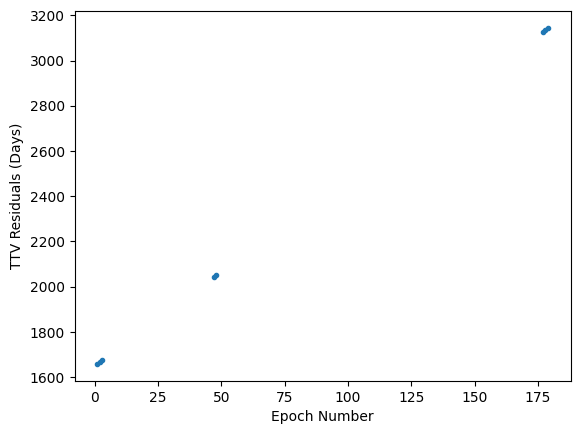

In [29]:
errors = [lowererrminutes, uppererrminutes]
errorsday = [lower, upper]
plt.plot(timeepoch, t0values, '.')
plt.xlabel("Epoch Number")
plt.ylabel("TTV Residuals (Days)")
#plt.errorbar(timeepoch, CTTresidualsminutes, yerr=error, fmt='o', ecolor='blue', capsize=5, label='Data with error bars')

In [30]:
#MCMC Fitting for the Residual Calculation

In [31]:
def ttv_function(d, t, s, t0):
    return t0 + t*s + 1/2*d*(t**2)


In [32]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    s, t0, d = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if -10<s<10: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

In [33]:
# Define Likelihood Function
def log_likelihood(parameters, time, ttv, ttv_err):
    ## Get our parameters for the model
    s, t0, d = parameters
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = ttv_function(d, time, s, t0)
    
    ## Compare using chi squared
    chisquared = np.nansum(((ttv-model)**2/(ttv_err**2)))
    ## Return our chi squared value for later evaluation done by emcee
    return (-0.5 * chisquared)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:23<00:00, 209.86it/s]


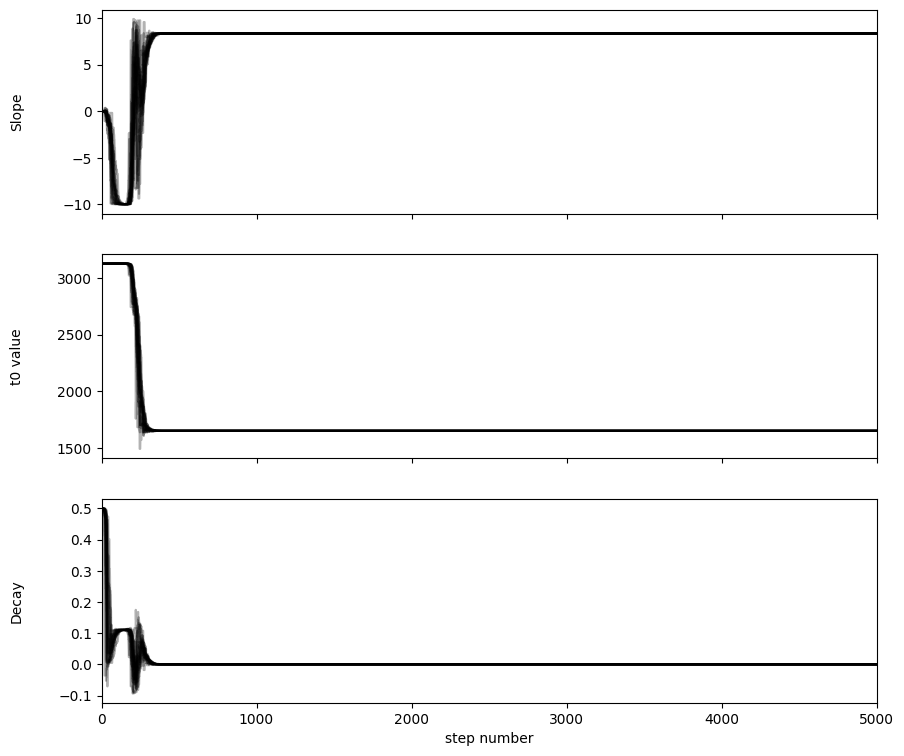

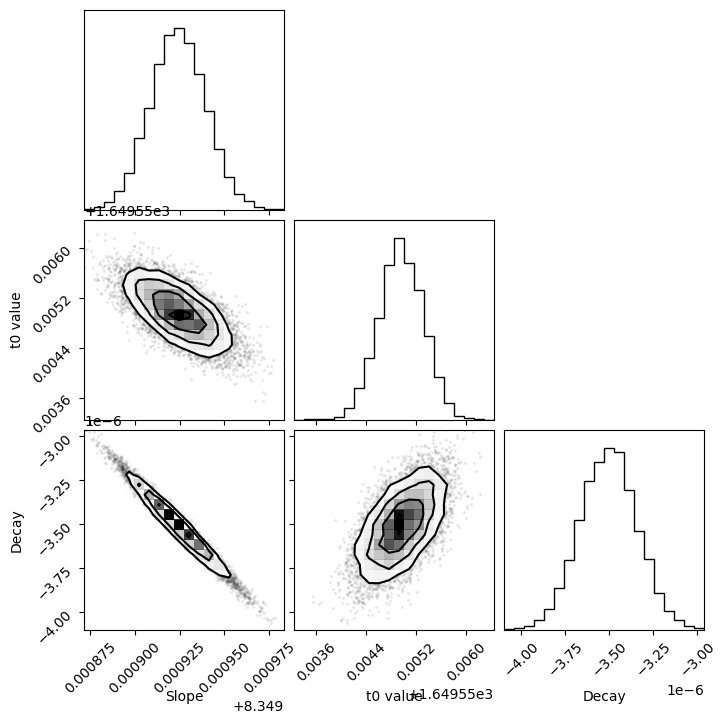

In [34]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 3
nwalkers = 24

random_additions = np.random.rand(nwalkers, ndim) * 0.001

p0 = np.add(np.asarray([0,epochs[0],0.5]), random_additions)

# Declare the sampler for the current epoch
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood,
    args=(np.asarray(timeepoch), np.asarray(t0values), np.asarray(errorsday))
)
sampler.run_mcmc(p0, 5000, progress=True)

    
fig, axes = plt.subplots(ndim, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ['Slope', 't0 value', 'Decay']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
flat_samples = sampler.get_chain(discard=1000, thin=11, flat=True)
fig = corner.corner(flat_samples, labels=labels)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

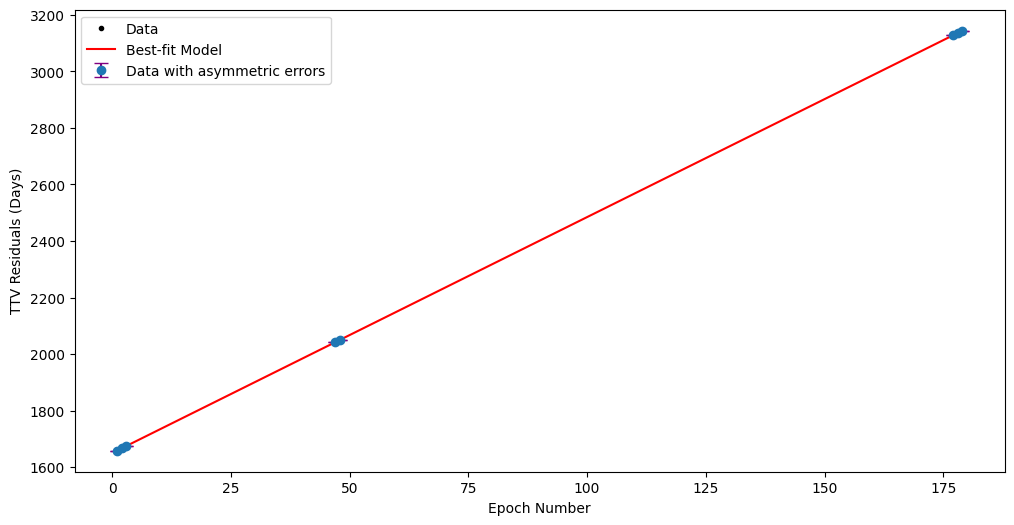

In [35]:
# Calculate and display median and uncertainties for t0
answers = []
err = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [0.3, 50, 99.7])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    answers.append(mcmc[1])
    err.append(q[0])
    err.append(q[1])
    display(Math(txt))

# Update model with best-fit t0 to plot the fitted light curve
s = answers[0]
t0 = answers[1]
decay = answers[2]
best_fit = ttv_function(decay,np.asarray(timeepoch),s,t0)  

# Plot data and best-fit model for the current epoch
plt.figure(figsize=(12, 6))
plt.plot(np.asarray(timeepoch), t0values, "k.", label="Data")
plt.plot(np.asarray(timeepoch), best_fit, "r-", label="Best-fit Model")
error = [lowererrminutes, uppererrminutes]
plt.errorbar(np.asarray(timeepoch), t0values, yerr=np.asarray(errorsday), ecolor='purple', fmt='o', capsize=5, label="Data with asymmetric errors")
plt.xlabel("Epoch Number")
plt.ylabel("TTV Residuals (Days)")
plt.legend()
plt.show()

In [36]:
CTTresiduals = []
modelvalues = []
planet_number = []
for t0value, epoch in zip(t0values, timeepoch):
    model = (s * epoch + t0 + 0.5 * decay * (epoch ** 2))
    modelvalues.append(model)
    residual = t0value - model
    CTTresiduals.append(residual)
    planet_number.append(0)
print(CTTresiduals)

[np.float64(-0.001328093416759657), np.float64(-0.0002981249881486292), np.float64(0.0017388562405358243), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(0.0003634764389062184), np.float64(-0.0003890061875608808), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.float64(nan), np.flo

In [37]:
import pandas as pd

data = {
    'Planet Number': planet_number,
    'Epoch': timeepoch,
    'T0 Observed': t0values,
    'Model Prediction': modelvalues,
    'CTT Residuals': CTTresiduals
}

df = pd.DataFrame(data)
df.to_csv('CTTresidualsC_Planet_Outer.csv', index=False)

In [ ]:
#EXPERIMENTATION FROM THIS POINT ONWARDS

In [36]:
# Define Priors - The boundaries on what is allowed for our model
## Returning 0 shows that the values are valid for the model
## Returning -infinity shows that the values are not valid for the model
def log_prior(theta):
    ## Get our parameters for the model
    s, t0, d = theta
    
    ## Check if the t0 value is less than or greater than 0.1
    if -10<s<10: # !! Change these if you want a more constrained fit
        return 0
    
    return -np.inf

In [37]:
# Define Likelihood Function
def log_likelihood(parameters, time, ttv, ttv_err):
    ## Get our parameters for the model
    s, t0, d = parameters
    
    ## Check our parameters against our priors
    ## If lp is negative infinity, the values are invalid, a model will not be calculated, 
    ##  and these values will be labeled as very unlikely
    lp = log_prior(parameters)
    if not np.isfinite(lp):
        return -np.inf
    
    ## Generate a new version of our model using our current x values
    model = ttv_function(d, time, s, t0)
    
    ## Compare using chi squared
    chisquared = np.nansum(((ttv-model)**2/(ttv_err**2)))
    ## Return our chi squared value for later evaluation done by emcee
    return (-0.5 * chisquared)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 998.36it/s]


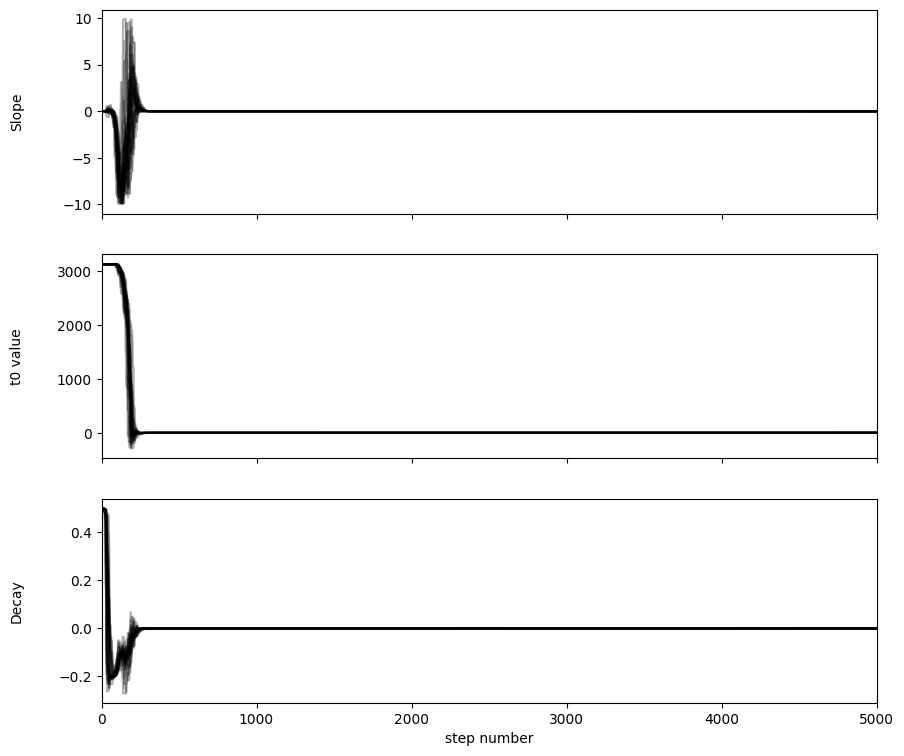

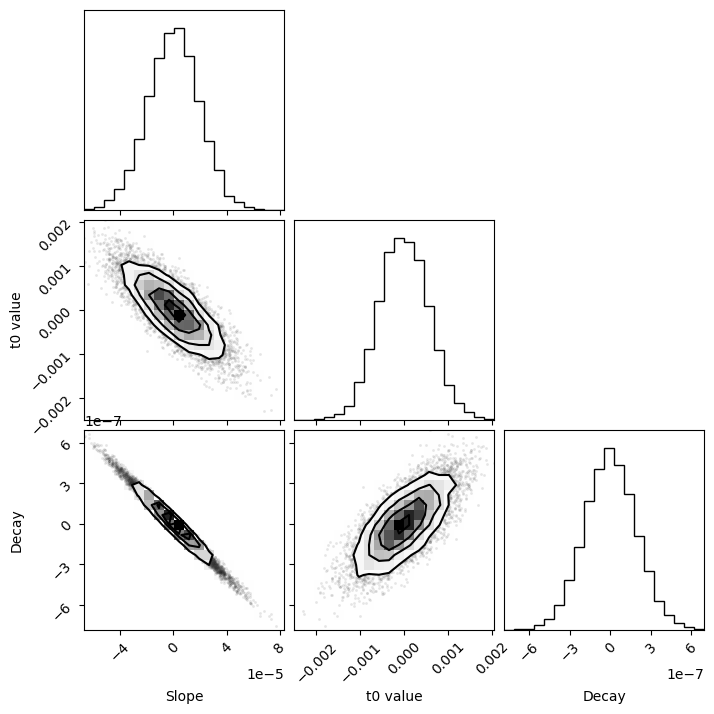

In [38]:
# Example data (replace `t`, `flux`, and `error` with your actual data arrays)
# t, flux, error = ... (define these as lists of arrays per epoch)
# epochs = ... (define epochs array)

ndim = 3
nwalkers = 24

random_additions = np.random.rand(nwalkers, ndim) * 0.001

p0 = np.add(np.asarray([0,epochs[0],0.5]), random_additions)

# Declare the sampler for the current epoch
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_likelihood,
    args=(np.asarray(timeepoch), np.asarray(CTTresiduals), np.asarray(errorsday))
)
sampler.run_mcmc(p0, 5000, progress=True)

    
fig, axes = plt.subplots(ndim, figsize=(10, 9), sharex=True)
samples = sampler.get_chain()
labels = ['Slope', 't0 value', 'Decay']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

# Discard burn-in samples, flatten chain, and plot corner plot for posterior distribution
flat_samples = sampler.get_chain(discard=1000, thin=11, flat=True)
fig = corner.corner(flat_samples, labels=labels)
plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

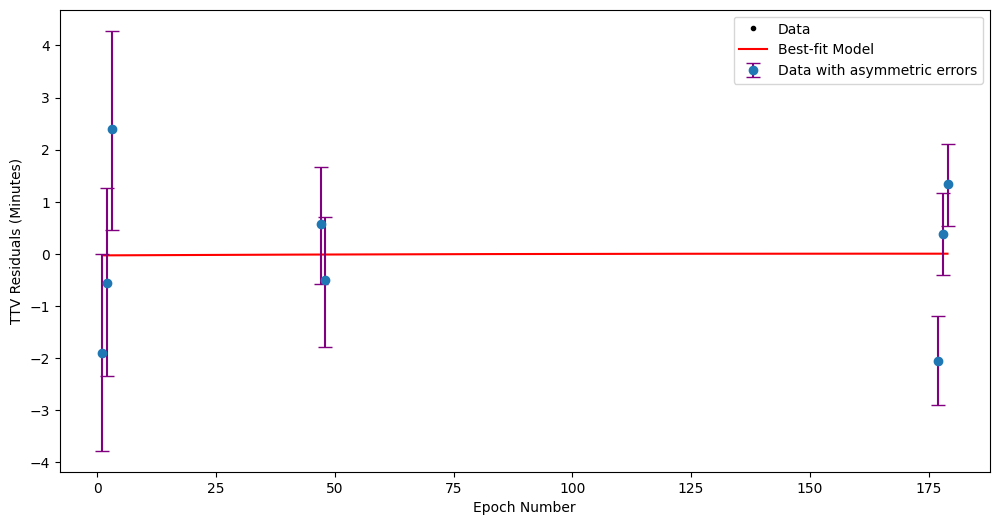

In [39]:
# Calculate and display median and uncertainties for t0
answers = []
err = []
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [2.1, 50, 97.9])
    q = np.diff(mcmc)
    txt = r"\mathrm{{{3}}} = {0:.7f}_{{-{1:.7f}}}^{{+{2:.7f}}}"
    txt = txt.format((mcmc[1]*24*60), (q[0]*24*60), (q[1]*24*60), labels[i])
    answers.append((mcmc[1]*24*60))
    err.append((q[0]*24*60))
    err.append((q[1]*24*60))
    display(Math(txt))

# Update model with best-fit t0 to plot the fitted light curve
s = answers[0]
t0 = answers[1]
decay = answers[2]
best_fit = ttv_function(decay,np.asarray(timeepoch),s,t0)   

# Plot data and best-fit model for the current epoch
plt.figure(figsize=(12, 6))
plt.plot(np.asarray(timeepoch), np.asarray(CTTresiduals)*24*60, "k.", label="Data")
plt.plot(np.asarray(timeepoch), best_fit, "r-", label="Best-fit Model")
error = [lowererrminutes, uppererrminutes]
plt.errorbar(np.asarray(timeepoch), np.asarray(CTTresiduals)*24*60, yerr=error , ecolor='purple', fmt='o', capsize=5, label="Data with asymmetric errors")
plt.xlabel("Epoch Number")
plt.ylabel("TTV Residuals (Minutes)")
plt.legend()
plt.show()